In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

target_directory = "mnist"

mnist_real_train = MNIST(target_directory, train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST(target_directory, train=False, download=True, transform=transforms.ToTensor())

100.1%

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


113.5%

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


100.4%

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


180.4%

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/home/mateusz/anaconda3/envs/newbase/lib/python3.9/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-28c20jpw/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
mnist_train, mnist_validation = data.random_split(mnist_real_train, (48000, 12000))
len(mnist_train), len(mnist_validation), len(mnist_test)

(48000, 12000, 10000)

In [4]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

In [5]:
layers = [
    nn.Conv2d(1, 6, 5, padding=2),
    nn.Tanh(),
    torch.nn.AvgPool2d(kernel_size=2),
    nn.Tanh(),
    nn.Conv2d(6, 16, 5),
    nn.Tanh(),
    torch.nn.AvgPool2d(kernel_size=2),
    nn.Tanh(),
    nn.Conv2d(16, 120, 5),
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
]

In [6]:
model = nn.Sequential(*layers)

cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())
print(model)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Tanh()
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Tanh()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Tanh()
  (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (9): Tanh()
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=120, out_features=84, bias=True)
  (12): Tanh()
  (13): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
train_loss = []
validation_acc = []
best_model = None
best_acc = None
best_epoch = None
max_epoch = 10000
no_improvement = 5
batch_size = 512

for n_epoch in range(max_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    train_loss.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X)
    acc = compute_acc(logits, y).detach()
    validation_acc.append(acc)
    if best_acc is None or acc > best_acc:
        print("New best epoch ", n_epoch, "acc", acc)
        best_acc = acc
        best_model = model.state_dict()
        best_epoch = n_epoch
    if best_epoch + no_improvement <= n_epoch:
        print("No improvement for", no_improvement, "epochs")
        break
        

New best epoch  0 acc tensor(0.9028)
New best epoch  1 acc tensor(0.9380)
New best epoch  2 acc tensor(0.9558)
New best epoch  3 acc tensor(0.9621)
New best epoch  4 acc tensor(0.9708)
New best epoch  5 acc tensor(0.9751)
New best epoch  6 acc tensor(0.9762)
New best epoch  7 acc tensor(0.9781)
New best epoch  8 acc tensor(0.9824)
New best epoch  10 acc tensor(0.9826)
New best epoch  11 acc tensor(0.9842)
New best epoch  14 acc tensor(0.9855)
New best epoch  18 acc tensor(0.9856)
New best epoch  19 acc tensor(0.9860)
New best epoch  22 acc tensor(0.9867)
No improvement for 5 epochs


In [8]:
loader = data.DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=False)
X, y = next(iter(loader))
logits = model(X)
acc = compute_acc(logits, y).detach()
print("Ocena na zbiorze testowym: " + str(round(float(acc),4)))

Ocena na zbiorze testowym: 0.986


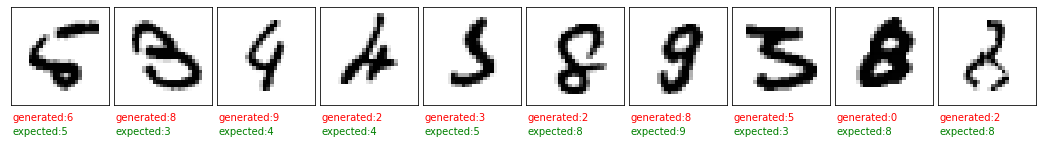

In [9]:
fig = plt.figure(figsize=(40, 40))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

cnt = 0
for i in range(len(logits)):
    if logits.argmax(dim=1)[i] == y[i]:
        continue
    ax = fig.add_subplot(28, 28, cnt + 1, xticks=[], yticks=[])
    ax.imshow(X.reshape(-1, 28, 28)[i], cmap=plt.cm.binary, interpolation='nearest')
    cnt += 1

    ax.text(0, 32, "generated:" + str(logits.argmax(dim=1)[i].item()), color='red')
    ax.text(0, 36, "expected:" + str(y[i].item()), color='green')
    if(cnt == 10):
        break